In [1]:
import sys
import time
import pickle
import numpy as np
from tqdm import tqdm
from pathlib import Path

import tensorflow as tf
import matplotlib.pyplot as plt

from openeye import oechem, oedepict, oeomega, oeszybki
import oenotebook as oenb
assert oechem.OEChemIsLicensed(), "OpenEye License not found!"

In [2]:
%matplotlib inline

In [3]:
font = {'family': 'Arial',
        'weight': 'normal',
        'size': 14}
plt.rc('font', **font)

In [4]:
sys.path.append(str(Path().resolve().parent))

In [5]:
from torsion.utils.process_sd_data import dump_sd_data, get_sd_data
from torsion.dihedral import get_dihedral
from torsion.utils.plotting import oenb_draw_dihedral
from torsion.inchi_keys import get_specific_dihedral_inchi_key
from torsion.model import get_sf_elements, get_model

In this notebook, we will use TorsionNet to generate a torsional energy profile for a torsional fragment. We will pick one of the fragments for which we already have QM data.

### Pick a fragment

In [6]:
qm_confs = "../data/TorsionNet500_qm_opt_geometries.sdf"
ANGLE_TAG  = "TORSION_ANGLE"
ENERGY_TAG = "Energy"

In [7]:
qm_ifs = oechem.oemolistream()
if not qm_ifs.open(qm_confs):
    raise ValueError(f"Unable to open {qm_confs} for reading.")

qm_conformer_list = []
qm_conformer_name_list = []
start_time = time.time()
angle = []
qm_energy = []
for mol_no, mol in enumerate(qm_ifs.GetOEGraphMols()):
    if (mol_no+1) % 1000 == 0:
        print(f"Read QM conformer no. {mol_no+1:6d}", end='\r', flush=True)
    qm_conformer_name = get_specific_dihedral_inchi_key(mol) + '-' + str(int(get_sd_data(mol, 'TORSION_ANGLE')) % 360)
    qm_conformer_name_list.append(qm_conformer_name)
    angle.append(float(get_sd_data(mol, ANGLE_TAG)))
    qm_energy.append(float(get_sd_data(mol, ENERGY_TAG)))
    qm_conformer_list.append(oechem.OEGraphMol(mol))
print(f"\nin {time.time() - start_time:.0f}s")
qm_energy = np.array(qm_energy).reshape((-1, 24))
qm_energy -= np.expand_dims(qm_energy.min(axis=1), axis=1)
angle = np.array(angle).reshape((-1, 24))

Read QM conformer no.  12000
in 15s


In [8]:
unique_conformer_name_list = ['-'.join(x.split('-')[:-1]) for x in qm_conformer_name_list]
N_frags = len(set(unique_conformer_name_list))

Let's pick one of our fragments:

SMILES string for fragment: c1ccc2c(c1)ncn2c3ccccn3


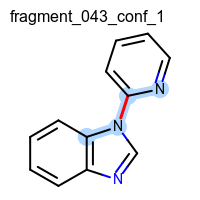

In [9]:
frag_idx = 42
assert 0 <= frag_idx < N_frags, f"Pick a fragment index between 0 and {N_frags-1}"

smi = oechem.OEMolToSmiles(qm_conformer_list[frag_idx*24])
print(f"SMILES string for fragment: {smi}")
oenb_draw_dihedral(qm_conformer_list[frag_idx*24])

In [10]:
y_qm = qm_energy[frag_idx]

### Start from SMILES and one torsion of interest

Now let's start from the SMILES string and generate a torsional profile.

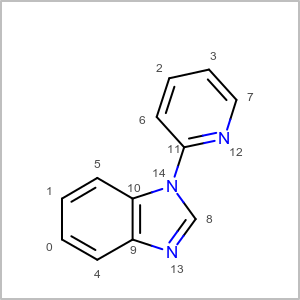

In [11]:
mol = oechem.OEMol()
oechem.OESmilesToMol(mol, smi)

# Build 3D conformer
builder = oeomega.OEConformerBuilder()
ret_code = builder.Build(mol)
if not ret_code == oeomega.OEOmegaReturnCode_Success:
    oechem.OEThrow.Warning("%s: %s" % (mol.GetTitle(), oeomega.OEGetOmegaError(ret_code)))

opts = oedepict.OE2DMolDisplayOptions()
opts = oedepict.OE2DMolDisplayOptions(300, 300, oedepict.OEScale_AutoScale)
opts.SetAtomPropertyFunctor(oedepict.OEDisplayAtomIdx())
oenb.draw_mol(mol, opts=opts)

Let's mark our torsion atoms

Data Attached at the molecule level:
TORSION_ATOMS_FRAGMENT : 11 15 12 13


----------Data Attached to Conformers:
Data attached to conformer 0:



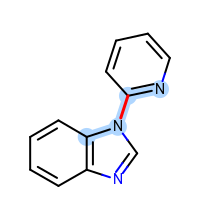

In [12]:
torsion_atom_indices = [10, 14, 11, 12]
oechem.OESetSDData(mol, "TORSION_ATOMS_FRAGMENT", " ".join(str(x+1) for x in torsion_atom_indices))
dump_sd_data(mol)
oenb_draw_dihedral(mol)

### Generate Torsional Conformers

In [13]:
num_points = 24

In [14]:
delta = 360.0/num_points
angle_list = np.linspace(-oechem.Pi, oechem.Pi, num_points+1)[1:]
angle_list = angle_list.tolist()

dih, _ = get_dihedral(mol, torsion_atom_indices)
dih_atoms = [x for x in dih.GetAtoms()]

# Create new output OEMol
title = mol.GetTitle()
tor_mol = oechem.OEMol()

opts = oeszybki.OETorsionScanOptions()
opts.SetDelta(delta)
opts.SetForceFieldType(oeszybki.OEForceFieldType_MMFF94)
opts.SetSolvationType(oeszybki.OESolventModel_NoSolv)
tmp_angle = 0.0
tor = oechem.OETorsion(dih_atoms[0], dih_atoms[1], dih_atoms[2], dih_atoms[3], tmp_angle)

oeszybki.OETorsionScan(tor_mol, mol, tor, opts)
oechem.OECopySDData(tor_mol, mol)

# if 0 and 360 sampled because of rounding 
if tor_mol.NumConfs() > num_points:
    for conf in tor_mol.GetConfs():
        continue
    tor_mol.DeleteConf(conf)

for angle, conf in zip(angle_list, tor_mol.GetConfs()):
    angle_deg = int(round(angle*oechem.Rad2Deg))
    tor_mol.SetActive(conf)
    oechem.OESetTorsion(conf, dih_atoms[0], dih_atoms[1], dih_atoms[2], dih_atoms[3], angle)

    conf_name = title + '_{:02d}'.format(conf.GetIdx())
    oechem.OESetSDData(conf, 'CONFORMER_LABEL', conf_name)
    oechem.OESetSDData(conf, 'TORSION_ANGLE', "{:.0f}".format(angle_deg))
    conf.SetDoubleData('TORSION_ANGLE', angle_deg)
    conf.SetTitle('{}: Angle {:.0f}'.format(conf_name, angle_deg))


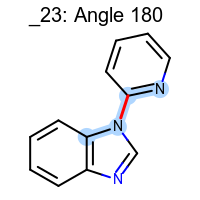

In [15]:
oenb_draw_dihedral(tor_mol)

In [16]:
torsional_mols = []
for conf in tor_mol.GetConfs():
    new_mol = oechem.OEMol(conf)
    oechem.OECopySDData(new_mol, mol)
    torsional_mols.append(new_mol)

In [17]:
torsional_mols

[<'oechem.OEMol' _00: Angle -165 c1ccc2c(c1)ncn2c3ccccn3 >,
 <'oechem.OEMol' _01: Angle -150 c1ccc2c(c1)ncn2c3ccccn3 >,
 <'oechem.OEMol' _02: Angle -135 c1ccc2c(c1)ncn2c3ccccn3 >,
 <'oechem.OEMol' _03: Angle -120 c1ccc2c(c1)ncn2c3ccccn3 >,
 <'oechem.OEMol' _04: Angle -105 c1ccc2c(c1)ncn2c3ccccn3 >,
 <'oechem.OEMol' _05: Angle -90 c1ccc2c(c1)ncn2c3ccccn3 >,
 <'oechem.OEMol' _06: Angle -75 c1ccc2c(c1)ncn2c3ccccn3 >,
 <'oechem.OEMol' _07: Angle -60 c1ccc2c(c1)ncn2c3ccccn3 >,
 <'oechem.OEMol' _08: Angle -45 c1ccc2c(c1)ncn2c3ccccn3 >,
 <'oechem.OEMol' _09: Angle -30 c1ccc2c(c1)ncn2c3ccccn3 >,
 <'oechem.OEMol' _10: Angle -15 c1ccc2c(c1)ncn2c3ccccn3 >,
 <'oechem.OEMol' _11: Angle 0 c1ccc2c(c1)ncn2c3ccccn3 >,
 <'oechem.OEMol' _12: Angle 15 c1ccc2c(c1)ncn2c3ccccn3 >,
 <'oechem.OEMol' _13: Angle 30 c1ccc2c(c1)ncn2c3ccccn3 >,
 <'oechem.OEMol' _14: Angle 45 c1ccc2c(c1)ncn2c3ccccn3 >,
 <'oechem.OEMol' _15: Angle 60 c1ccc2c(c1)ncn2c3ccccn3 >,
 <'oechem.OEMol' _16: Angle 75 c1ccc2c(c1)ncn2c3ccccn3 >,

### Generate Descriptors

In [18]:
X = []
for x in tqdm(torsional_mols):
    X.append(get_sf_elements(x))
X = np.array(X)

100%|██████████| 24/24 [00:00<00:00, 34.73it/s]


In [19]:
X.shape

(24, 293)

In [20]:
scaler_file = 'scaler.pkl'

In [21]:
with open(scaler_file, 'rb') as fptr:
    scaler = pickle.load(fptr)
X = scaler.transform(X)    

### Make predictions

In [22]:
model_file = 'model.h5'

In [23]:
model = tf.keras.models.load_model(model_file)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2930)              861420    
_________________________________________________________________
batch_normalization (BatchNo (None, 2930)              11720     
_________________________________________________________________
dropout (Dropout)            (None, 2930)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1465)              4293915   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1465)              5860      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1465)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 293)               4

In [24]:
y_pred = model.predict(X).flatten()
y_pred -= y_pred.min()

In [25]:
y_pred

array([1.0792285 , 0.4540347 , 0.27242333, 2.0337684 , 3.930876  ,
       4.8680935 , 4.749976  , 2.147114  , 1.0135015 , 0.5080031 ,
       0.5699425 , 1.047332  , 1.7667468 , 1.2362846 , 2.1199944 ,
       3.4932525 , 4.3059325 , 4.2198305 , 3.757469  , 1.8737566 ,
       0.26430243, 0.        , 0.3084569 , 1.2566639 ], dtype=float32)

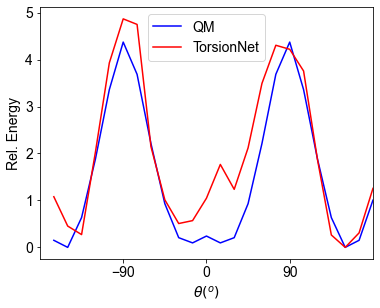

In [26]:
angles = [(x*180/np.pi) for x in angle_list]

fig = plt.figure(figsize=(2*2.75,2*2.25))
ax = fig.add_subplot(111)
ax.plot(angles, y_qm, 'b-', label='QM')
ax.plot(angles, y_pred, 'r-', label='TorsionNet')
ax.set_xticks([-90, 0, 90])
ax.set_xlim([-180, 180])
ax.set_xlabel(r"$\theta (^o)$")
ax.set_ylabel("Rel. Energy")
ax.legend(loc='best')
fig.tight_layout()